In [8]:
import modal
from egfr_binder_rd2.utils import hash_seq, load_evolution_metadata
from egfr_binder_rd2 import EGFR, EGFS, OFFICIAL_EGFR
import pandas as pd
from pathlib import Path
from egfr_binder_rd2 import MODAL_VOLUME_PATH, OUTPUT_DIRS
from egfr_binder_rd2.fold import get_a3m_path
import seaborn as sns
from egfr_binder_rd2.solubility import calculate_solubility
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

get_msa = modal.Function.lookup("simplefold", 'get_msa_for_binder')
# a3m_from_template = modal.Function.lookup("simplefold", 'a3m_from_template')
fold_binder = modal.Function.lookup("simplefold", 'fold_binder')
update_metrics = modal.Function.lookup("simplefold", 'update_metrics_for_all_folded')
esm2_pll = modal.Function.lookup("esm2-inference", 'process_sequences')
esm2_pll_exact = modal.Function.lookup("esm2-inference", 'process_sequences_exact')
update_pll_metrics = modal.Function.lookup("esm2-inference", 'update_pll_metrics')
get_exact_plls = modal.Function.lookup("esm2-inference", 'update_exact_pll_metrics')
sample_sequences = modal.Function.lookup("bt-training", 'sample_sequences')
update_high_quality_metrics = modal.Function.lookup("simplefold", 'update_high_quality_metrics')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
hq_results, top_ranked = update_high_quality_metrics.remote()

In [27]:
metrics = update_metrics.remote()

In [4]:
merged = top_ranked.add_prefix('exact_').merge(metrics, left_on='exact_binder_sequence', right_on='binder_sequence', how='left')

In [21]:
merged

NameError: name 'merged' is not defined

Text(0, 0.5, 'PAE Interaction')

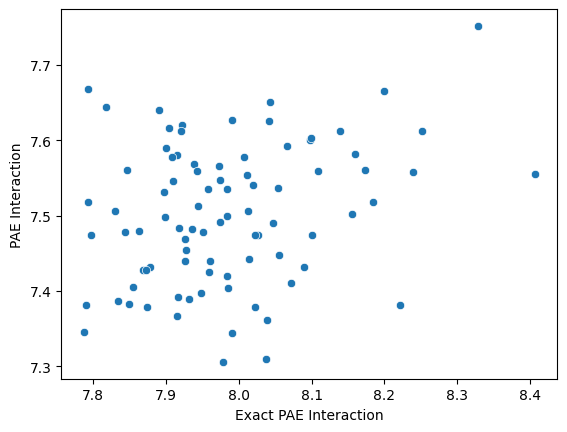

In [6]:
f,ax = plt.subplots()
sns.scatterplot(data=merged.query('pae_interaction < 8'), x='exact_pae_interaction', y='pae_interaction', ax=ax)
# Add unity line
# ax.plot([7, 9], [7, 9], 'k--', alpha=0.5)
ax.set_xlabel('Exact PAE Interaction')
ax.set_ylabel('PAE Interaction')



In [35]:
metrics.query('pae_interaction < 8').sort_values('p_soluble', ascending=False)

,seq_hash,binder_sequence,binder_length,target_sequence,target_length,model_number,binder_plddt,binder_pae,pae_interaction,ptm,i_ptm,binder_charged_fraction,binder_hydrophobic_fraction,parent_hash,parent_sequence,mutations,binder_hydrophobicity,binder_hydropathy,binder_solubility,p_soluble
305,0c9f67,TYDGYCLNGGKCEHVESLDKYTCNCVSGYTGDRCQERDLRWLEHQ,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,90.104667,3.594988,7.916933,0.86,0.93,0.333333,0.244444,8f57ac,TYDGYCLNGGKCEHVESLDKYTCNCVSGYTGDRCQERDLRWLEHR,R45Q,0.285451,0.387901,0.471832,0.360528
2197,5b6d70,TYDGMCLNNGVCRHIESLDSYTCHCEQGYEGDRCQKEDLRWLELK,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,90.284000,3.586568,7.946930,0.86,0.93,0.355556,0.266667,03b7e6,YYDGMCLNKGVCRHIESLDSYTCHCEQGYEGDRCQKQDLRWLELK,"Y1T,K9N,Q37E",0.302893,0.400000,0.472083,0.358339
3587,942bea,SYDGYCNNRGVCRHIESLDSYTCKCDQGYEGDRCQTRDLRWLELH,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,89.932889,3.540040,7.990285,0.86,0.94,0.355556,0.244444,7535a1,SYDGYCNNRGVCRHIESLDSNTCQCDQGYEGDRCQTRDLRWLELR,"N21Y,Q24K,R45H",0.292746,0.376790,0.490237,0.219320
4916,cbceab,DYDGYCLNKGVCHRVESLNSYTCECRKGYSGDRCQTRDLKWLELQY,46,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,88.940217,3.766356,7.975716,0.87,0.93,0.326087,0.282609,39e45e,SYDGYCLNKGVCHRIESLNSYTCNCRRGYSGDRCQTRDLKWLELQY,"S1D,I15V,N24E,R27K",0.312141,0.392995,0.497467,0.176067
2794,72da1a,SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,89.974222,3.664943,7.964247,0.86,0.94,0.311111,0.244444,7535a1,SYDGYCNNRGVCRHIESLDSNTCQCDQGYEGDRCQTRDLRWLELR,"R9H,N21W,D26R,R45N",0.286205,0.378765,0.497817,0.174151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,8313b1,SLFSACPSRYCGICKNNGVCRYAISLRSYTCVCVSGYTGYRCQELD...,54,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,92.002222,3.353519,7.533247,0.87,0.95,0.166667,0.370370,68137c,SLFSACPSRYHGICKNNGVCRYAISLRSSTCHCVSGYTGYRCQELD...,"H11C,S29Y,H32V,I48R,H49F",0.365199,0.520576,0.592613,0.005800
2170,5a7ef1,CSFSACPSMYLGICSNGGVCRYIQTLNSYTCQCLYGYTGDRCQTFD...,54,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,90.122407,3.891091,7.997321,0.87,0.94,0.111111,0.370370,633d58,HSFSACPSSYLGICSNGGVCRYIQTLTSYTCQCPYGYTGDRCQTFD...,"H1C,S9M,T27N,P34L",0.347240,0.535391,0.593948,0.005516
4635,bf0dbd,SMFSACPDIYEGSCCNGGVCRYIQTLTSYTCQCCYGYTGDRCQTFD...,54,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,90.858148,3.837462,7.796945,0.87,0.94,0.129630,0.351852,bdec0a,SMFSACPDIYEGSCSNGGVCRYIQTLTSYTCQCCPGYTGDRCQTFD...,"S15C,P35Y",0.349266,0.522428,0.596526,0.005006
6071,fc32e8,YLFSVCPYRYHGICKNNGQCRYAISLRSGTCHCVSGYTGYRCQYID...,54,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,90.613704,3.703484,7.804232,0.87,0.94,0.166667,0.407407,ca13fe,YLFSVCPYRYHGICKNNGQCRYAISLRSGTCHCVSGYTGYRCQEID...,E44Y,0.389308,0.495062,0.596730,0.004967


In [36]:
metrics.query('pae_interaction < 9.2').sort_values('pae_interaction', ascending=True).iloc[0]['binder_sequence']

'GLFSICPRRYRGICTNNGSCRYAINLRTYTCQCVSGYTGARCQELDIRYLLLLY'

In [28]:
metrics

,seq_hash,binder_sequence,binder_length,target_sequence,target_length,model_number,binder_plddt,binder_pae,pae_interaction,ptm,i_ptm,binder_charged_fraction,binder_hydrophobic_fraction,parent_hash,parent_sequence,mutations,binder_hydrophobicity,binder_hydropathy,binder_solubility,p_soluble
0,000672,GYDKYCLNRGACQHIESLDSYTCKCLSGYTGHRCQTQDLRWLELR,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,89.218000,3.836751,8.186952,0.85,0.93,0.288889,0.266667,c6e7a9,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR,"S1G,G4K,V11A,P27S,D32H",0.305325,0.415309,0.513938,0.102791
1,002066,PSFSACPSNYDGLCCNGGVCHHAASLTSYTCQCPRGYSGHRCQTLD...,55,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,84.067636,5.635395,9.469180,0.85,0.90,0.200000,0.218182,6977c4,PSFSACPSNYDGWCCNGGVCHHAESLTSYTCQCPLGYSGHRCQTLD...,"W13L,E24A,L35R,Y49I,E51I",0.298868,0.463636,0.536774,0.046053
2,0024ce,SLFSSCPRRMQGICKNNGTCRYVRNLRTYSCQCVSGYTGARCQELD...,54,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,92.176296,3.198474,7.433887,0.87,0.95,0.185185,0.333333,e8656d,SLFSSCPRRMQGICKNNGTCRYVLNLRTYSCQCVSGYTGARCQELD...,L24R,0.325017,0.471811,0.569067,0.014023
3,00332c,HYDGMCGNKGVCRHIESLDSYTCHCEQGYEGDRCQTQNLRWLELR,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,88.282667,3.938193,8.455232,0.85,0.92,0.333333,0.244444,e54e34,EYDGMCLNKGVCRHIESLDSYTCHCEQGYEGDRCQTQDLRWLELR,"E1H,L7G,D38N",0.283354,0.388889,0.482675,0.272207
4,003442,PSFSACPSNYTGVCCNGGVCHLAESLTSYTCRCPLGYSGHRCQTFD...,55,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,86.082364,5.389940,8.996570,0.86,0.91,0.218182,0.218182,f2b3c7,PSFSACPSNYDGVCCNGGVCHLAESLTSYTCQCILGYSGHRVQTFD...,"D11T,Q32R,I34P,V42C,Y49R",0.290703,0.451919,0.533172,0.052426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6160,ffd904,NSYPECPSSYSGLCLNGGQCVHIESLDSYTCNCLPGYTGLRCQTRD...,53,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,85.003962,5.280605,9.219001,0.85,0.90,0.188679,0.283019,11d405,NSYPGCPSSYDGLCLNGGVCTHIESLDSYTCNCLPGYTGDRCQTRD...,"G5E,D11S,V19Q,T21V,D40L",0.318975,0.466876,0.530993,0.056677
6161,ffdee8,AERMRRRFEHIVEEHEEWAKEVLENLAKQGSEEEDLKEMEEYLEQD...,65,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,46.146154,5.753058,23.850198,0.62,0.33,0.569231,0.276923,f9aee7,AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQD...,"I14E,K27A,K32E,F38E,S64L",0.308563,0.340855,0.317896,0.994794
6162,ffe173,APPLSEIEKEGQKVIAEIEKALTPPPEYHNRLTWENYQKAFVLEME...,70,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,47.264714,7.798161,22.384739,0.66,0.37,0.314286,0.314286,9f3ef6,APPLSEIEKEGQKVIAEIEKALTPPPEYHNRLTWENYQKAFVLEME...,M68P,0.412291,0.433333,0.393933,0.914902
6163,ffe2df,HDEGFCHNHGVCKHQILLDKYTCRCKHGYVGDRCQTRDLRFLELR,45,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,622,1,85.810889,4.832405,8.750484,0.86,0.92,0.422222,0.266667,65c95b,DDEGFCHNAGVCKHQELLDKYTCRCKHGYTGDRCQTRDLRFLELK,"D1H,A9H,E16I,T30V,K45R",0.321845,0.407901,0.478276,0.306411


<Axes: xlabel='pae_interaction', ylabel='p_soluble'>

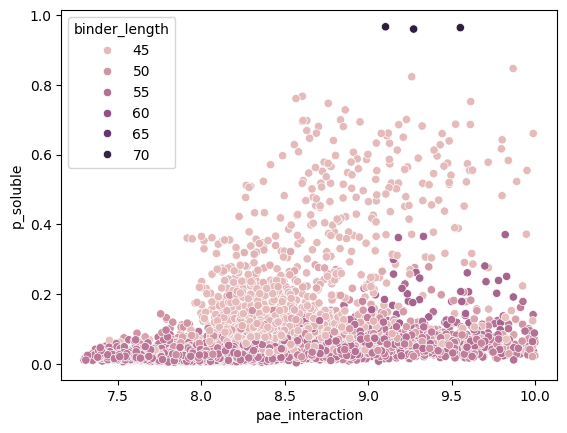

In [14]:
sns.scatterplot(data=metrics.query('pae_interaction < 10'), x='pae_interaction', y='p_soluble', hue='binder_length')


Text(0, 0.5, 'PTM')

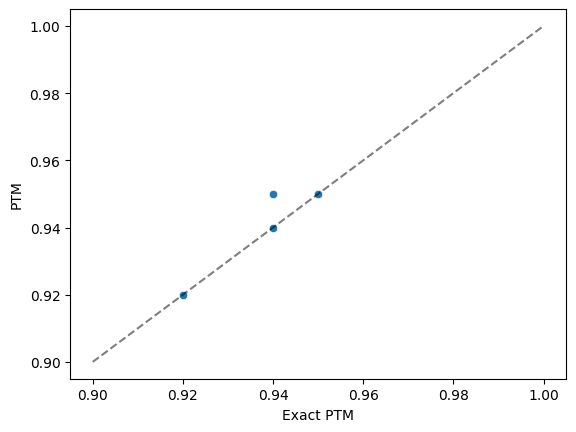

In [20]:
f,ax = plt.subplots()
sns.scatterplot(data=merged, x='exact_i_ptm', y='i_ptm', ax=ax)
# Add unity line
ax.plot([0.9, 1], [0.9, 1], 'k--', alpha=0.5)
ax.set_xlabel('Exact PTM')
ax.set_ylabel('PTM')


In [2]:
binder_seqs = [
    'WVQLQESGGGLVQPGGSLRLSCAASGRTFSSYAMGWFRQAPGKQREFVAAIRWSGGYTYYTDSVKGRFTISRDNAKTTVYLQMNSLKPEDTAVYYCAATYLSSDYSRYALPQRPLDYDYWGQGTQVTVSSLE:LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCKLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLRGCPTNGHHHHHH',
    'QVQLQESGGGLVQPGGSLRLSCAASGRTFSSHAMGWFRQAPGKQREFVAAIRWSGGYTYYTDSVKGRFTISRDNAKTTVYLQMNSLKPEDTAVYYCAATYLSSDYSRYALPQRPLDYDYWGQGTQVTVSSLE:LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCKLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLRGCPTNGHHHHHH',
    'SVDEECPASYEGFCQNDGTCLYLEKLDRYACRCREGYIGERCEFRDLDYWLEQ',
    'DSECPLSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALLGPGPPGVVEKEKYKVSITEKVNPGGPATMPMTLTDSNGNKTTLTITVTPEGLEAIRKRRAGEKVKYTMTSTDTGDKFVLVDLDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLK',
    'DSECPLSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALL',
    'NSDSECPLSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWELR',
    'AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQDVEELRKRAEEMVEEYEKSS',
]


In [9]:
parent_binder_seq = 'PSFSACPSNYDGYCMNGGVCHYFESLTSITCQCIIGYIGDRCQTFDLRYTELRR'
binder_seqs = ['PSFSACPSNYDGYCMNGGVCHYFESLTSITCQCIIGYIGDRCQTFDDRYTELRR']

result = fold_binder.remote(binder_seqs=binder_seqs, parent_binder_seqs=[parent_binder_seq])

In [11]:

# binder_seqs = ['AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQDVEELRKRAEEMVEEYEKSS']
binder_seqs = [
    'EKGHFKECPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRY',
    'EKGHFKECPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY'
    ]
binder_seqs = [
    # 'SYDGYCLNGGVCMHIESC',
    # 'ESGDYYQTRDLRWWELR',
    # 'ESGDYYQTRDLRWWELR',
    'ESGDYYQTRDLRWWERRM',
    'SYDGYCLNGGVCMHIES',
]
result = get_msa.remote(binder_seqs)


In [9]:
result = esm2_pll.remote()

In [3]:
result = esm2_pll.remote(binder_seqs)

In [10]:
parent_binder_seq = 'SKEEEYYEEHQKLAKPVEELWEKLDELEKTGKLTGEHRPLVTEFRRLWSDAMVLIAMYMWYLEEVDKNPSEENRKKAQEYLEKVEEKKKEMEELLKKL'
parent_binder_seq = 'PSFSACPSNYDGYCMNGGVCHYFESLTSITCQCIIGYIGDRCQTFDLRYTELR'

In [32]:
parent_binder_seq = 'PSFSACPSNYDGVCCNGGVCHLAESLTSYTCQCILGYSGHRVQTFDLRYTELRRR'
parent_binder_seq =         'SYDGYCLNGGVCMHIESLDSYTCNCIGYSGDRCQTRDLRWWELR'
parent_binder_seq =         'SYDGYCLNGCIGYSGDRCQTRDLRWWELR'
parent_binder_seq =         'SYDGYCLNGGVCMHSYTCNCIGYSGDRCQTRDLRWWELRE'

In [ ]:
'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRR'

In [2]:
seqs = [
    'SYDGYCLNGCIGYSGDRCQTRDLRWWELR',
    'SYDGYCLNGGVCMHSYTCNCIGYSGDRCQTRDLRWWELRE',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRR', 
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRRRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRRRRRR',
    'SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRRRRRRRRR',
    ]

In [28]:
seqs = [
    # 'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'LFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'FSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'SNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'NCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'CPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'PRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRY',
    'LFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLL',
    'FSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLL',
    'SNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLL',
    'NCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYL',
    'CPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRY',
    'PRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIR',
]

In [18]:
seqs = [
    'REEEEESICPRRYRGICTNNGSCRYAINLRTYTCQCVSGYTGARCQELDIRYEEEER'
]

In [19]:
result = get_msa.remote(seqs)

In [3]:
get_a3m_path('SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRR')

PosixPath('/colabfold_data/msa_results/d08924.a3m')

In [20]:
for seq in seqs:
    result = fold_binder.remote(binder_seqs=[seq])


In [22]:
result

[{'seq_hash': '3e86a2',
  'model_number': 1,
  'plddt': 91.33157584683357,
  'ptm': 0.86,
  'i_ptm': 0.88,
  'pae': 8.467343837099085}]

In [30]:
fdf = update_metrics.remote()
df = update_pll_metrics.remote()
fdf = fdf.merge(df, left_on='binder_sequence', right_on='sequence', how='left')
fdf['pae_interaction_rank'] = 1 - fdf['pae_interaction'].rank(pct=True)
fdf['i_ptm_rank'] = fdf['i_ptm'].rank(pct=True)
fdf['sequence_log_pll_rank'] = fdf['sequence_log_pll'].rank(pct=True)
fdf['p_soluble_rank'] = fdf['p_soluble'].rank(pct=True)
# fdf['fitness'] = (fdf['pae_interaction_rank'] + fdf['i_ptm_rank'] + fdf['sequence_log_pll_rank']) / 3
fdf['fitness'] = (fdf['pae_interaction_rank'] + fdf['i_ptm_rank'] + fdf['sequence_log_pll_rank'] + fdf['p_soluble_rank']) / 4
fdf = fdf.sort_values('fitness', ascending=False).reset_index(drop=True)


cols = [
    'seq_hash', 'binder_length', 'fitness', 'pae_interaction', 'i_ptm',  'sequence_log_pll', 'p_soluble',
      
       'pae_interaction_rank', 'i_ptm_rank',
       'sequence_log_pll_rank', 'p_soluble_rank',
       'binder_plddt', 'binder_hydropathy','binder_pae',
        'ptm', 'binder_charged_fraction',
       'binder_hydrophobic_fraction',
       'binder_sequence',
]
results = fdf[cols].round(3)

In [34]:
results.iloc[0]['binder_sequence']

'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN'

In [10]:
results.query('binder_length < 50')

,seq_hash,binder_length,fitness,pae_interaction,i_ptm,sequence_log_pll,p_soluble,pae_interaction_rank,i_ptm_rank,sequence_log_pll_rank,binder_plddt,binder_hydropathy,binder_pae,ptm,binder_charged_fraction,binder_hydrophobic_fraction,binder_sequence
512,f5effd,45,0.866,8.020,0.94,-107.506,0.130,0.800,0.856,0.942,89.567,0.397,3.693,0.86,0.289,0.267,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE
539,72da1a,45,0.861,7.964,0.94,-116.637,0.174,0.828,0.856,0.899,89.974,0.379,3.665,0.86,0.311,0.244,SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN
540,27d533,45,0.861,8.012,0.94,-113.166,0.122,0.804,0.856,0.923,89.875,0.384,3.716,0.86,0.289,0.244,SYNGYCKNGGQCQHIISLDQYTCRCESGYEGDRCQTRDLRWLELR
614,446a03,44,0.845,7.458,0.95,-202.558,0.050,0.988,0.968,0.578,93.206,0.386,2.647,0.86,0.227,0.227,CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIRY
630,2c86e8,44,0.842,7.734,0.93,-102.701,0.030,0.923,0.656,0.945,91.938,0.418,2.808,0.85,0.182,0.250,CPRRYRGICNNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,682898,29,0.118,20.739,0.47,-361.513,0.065,0.094,0.092,0.168,31.667,0.397,10.921,0.67,0.310,0.310,SMRLYCLNGHIGYSGRRCQTRDLRWHELQ
5580,66666d,45,0.114,19.733,0.53,-389.508,0.424,0.101,0.099,0.142,44.486,0.411,7.958,0.65,0.356,0.244,DIEERCLNQGVCLHAEPLDKYTCHCRHGYTGDNCQTRDLRFLELN
5640,b6151d,40,0.106,21.681,0.47,-386.690,0.298,0.079,0.092,0.147,29.653,0.413,14.315,0.66,0.275,0.325,SYDGYCLNGHVCMHSYTENHIGYSPDRAQTIDLGWYELRE
5768,da280c,45,0.088,21.852,0.40,-419.209,0.415,0.076,0.073,0.116,40.866,0.437,8.690,0.67,0.311,0.244,TDEGKCHNQGVCEHAESLDKYTCICVFGYTGDTCQTRDLRFLELN


In [ ]:
results.query('binder_length == 45').head(20)

In [32]:
top_guys =results.head(100)['binder_sequence'].to_list()
top_guys

['NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
 'NLFSNCPRRYRGICENNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
 'SLFSRCPKRYHGICNNNGQCRYAINLRTYTCICKSGYTGDRCQELDIRYLLLLN',
 'SLFSRCPRRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELDIRYLLLLN',
 'GLFSRCPKRYHGICGNNGQCRYAINLRTYTCRCVSGYTGPRCQELDIRYLLLLN',
 'NLFSNCPRRYRGICNNNGSCQYAINLRTYTCQCSSGYTGARCQELDIRYLLLLY',
 'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCSSGYTGARCQELDIRYLLLLY',
 'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN',
 'SLFSRCPRRYHGICHNNGQCRYAINLRTYTCRCVSGYTGDRCQEKDIRYLLLLY',
 'NLFSICPRRYRGICTNNGSCRYAINLRTYTCQCVSGYTGARCQELDIRYLLLLY',
 'SLFSRCPKRYHGICNNNGQCRYAINLRTYTCICVSGYTGDRCQELDIRYLLLLN',
 'GLFSRCPKRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELDIRYLLLLN',
 'SLFSRCPYRYHGICNNNGQCRYAINLRTYTCICVSGYTGDRCQELDIRYLLLLN',
 'ELFSRCPKRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELDIRYLLLLN',
 'NLFSRCPKRYHGICGNNGQCRYAIHLRTGTCRCVSGYTGRRCQELDIRYLLLLY',
 'SLFSRCPRRYYGICGNNGLCKYAINLRTGTCRCVSGYTGDRCQELDIRYLLLLN',
 'NLFSKCPRRYYGICGNNGRCKYAINLRTYTCRCVSGYTGQRCQEKDIRYLLLLN

In [78]:
len('SYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELR')

45

In [27]:
results.query('binder_length == 65').sort_values('i_ptm', ascending=False).head(20).iloc[2]['binder_sequence']

'AERMRRRFESIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQDVEELRKRAEEMVEEYEKSS'

In [2]:
def add_to_fasta(binder_seq, target_seq:str=OFFICIAL_EGFR, fasta_path:str='/home/naka/code/egfr_binder_rd2/data/fastas/rd2.fasta'):
    # Generate the full sequence and hash
    full_seq = f"{binder_seq}:{target_seq}"
    name = hash_seq(full_seq)
    
    # Read existing sequences if file exists
    existing_sequences = set()
    try:
        with open(fasta_path, 'r') as f:
            for line in f:
                if line.startswith('>'):
                    continue
                existing_sequences.add(line.strip())
    except FileNotFoundError:
        pass
    
    # Only append if sequence is new
    if full_seq not in existing_sequences:
        with open(fasta_path, 'a') as f:
            f.write(f'>{name}\n{full_seq}\n')


In [41]:
more_top_guys = ['CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIRY',
 'CPRRYNGICTNNGRCQYARNLHTYTCQCLPGYTKPRCQELDIRY',
 'CPRRYRGICTNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY',
 'SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR',
 'SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR',
 'SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR',
 'SNCPRRYRGICENNGTCKYATNLRTYTCQCLSGYTGARCQELDIRYLN',
 'SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR',
 'SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE',
 'SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN',
 'HYDGYCLNGGACRRIESLDSYTCQCQIGYSGDRCQTRDLRWLELQG',
 'CPARYNGICTNHGRCQYARNLRTYTCQCLPGYTKHRCQELDIRY',
 'SLFSNCPRRYRGICENNGSCRYAINLRRYTCQCLSGYTGYRCQELDIRYLLLLY',
 'CPRRYNGICTNNGSCQYAINLRTYTCQCLPGYTKPRCQELDIRY',
 'SYDGYCLNNGVCHHIESLDSYTCNCRVGYSGDRCQTADLRWLELYG',
 'NLFSNCPRRYHGICTNNGSCQYAINLRTYTCRCKSGYTGARCQEQDIRYL',
 'SYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM',
 'HYDGYCLNGGACRRIESLDSYTCQCQRGYSGDRCQTRDLRWLELQG',
 'HYDGYCLNGGECRRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQG',
 'SRCPRRYRGICENNGSCKYATNLRTYTCQCLSGYTGARCEELDIRYLL',
 'TYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM',
 'SYDGYCLNNGVCHHIESLDSYTCNCRVGYSGDRCQTMDLRWLERYM',
 'CPRMYRGICTNNGSCQYAINLRTYTCQCLPGYTGPRCQMLDIRY',
 'NCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYL',
 'HYDGYCLNGGACRRIESLHSYTCQCQIGYSGDRCQTRDLRWLELQN',
 'SLFSTCPRRYRGICHNNGSCRYAVNLRTYTCVCRSGYTGKRCQEADLRYLLLRY',
 'SYNGYCKNGGQCQHIISLDQYTCRCESGYEGDRCQTRDLRWLELR',
 'SYDGYCLNGGECRRIYSLHSYTCQCRIGYSGDRCQTRDLRYLELQG',
 'SNCPRRYRGICENNGSCKYRENLRTYTCQCLSGYTGARCQELDIRYLL',
 'SYDGYCNNRGVCRHIESLDSYTCKCDQGYEGDRCQTRDLRWLELH',
 'SNCPRRYRGICENNGSCRYRHNLRTYTCQCHSGYTGARCEELDIRYLL',
 'HYDGYCLNGGVCRRIESLHSYTCQCQIGYSGDRCQTRDLRWLELQW',
 'SYDGYCLNGGECRRIKSLHSYTCQCRIGYSGDRCQTRDLRYLELQQ',
 'CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIWY',
 'TYDGYCLNGGKCEHVESLDKYTCNCVSGYTGDRCQERDLRWLEHQ',
 'TYDGYCLNGGTCRRIESLNSYTCQCRIGYSGDRCQTRDLRYLELQW',
 'SYDGKCLNNGKCRYIEDLDSYTCQCESGYTGDRCQTRDLRWLELH',
 'KYDGYCNNHGECQHIHSLDSYTCKCLPGYEGDRCQTQDLRWLELR',
 'CPRRYRGICNNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY',
 'SYDGYCNNRGVCRHIESLDTYTCQCKQGYEGDRCETRDLRWLELY']

In [5]:
even_more_top_guys = [
    'AERMRRRFEHIVEIHEEWAKEVLEWLKKQGSKEEDYKFMEEYLEQDVKELRKRAEEMVEEYEKSG',
    'SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE'
]

In [7]:
for s in even_more_top_guys:
    add_to_fasta(s) 


In [3]:
import os
import json
import numpy as np

def get_metrics(
    output_folder, sequence_name, target_length=621
):  # the EGFR sequence has 621 residues
    files = os.listdir(output_folder)
    pae_file = f"{sequence_name}_predicted_aligned_error_v1.json"
    with open(os.path.join(output_folder, pae_file), "r") as f:
        pae = np.array(json.load(f)["predicted_aligned_error"])
    binder_len = (
        len(pae) - target_length
    )  # note that we are assuming that the binder always comes first in the sequence!
    pae_interaction = (
        pae[:binder_len, binder_len:].mean() + pae[binder_len:, :binder_len].mean()
    ) / 2
    scores = None
    for file in files:
        if file.startswith(f"{sequence_name}_scores_rank_001"):
            with open(os.path.join(output_folder, file), "r") as f:
                scores = json.load(f)
            break
    if scores is None:
        raise ValueError("No scores file found")
    iptm = scores["iptm"]
    return iptm, pae_interaction

In [4]:
from biotite.sequence.io.fasta import FastaFile

In [5]:
file = FastaFile().read('/home/naka/code/egfr_binder_rd2/data/fastas/rd2.fasta')

In [6]:
output_folder = '/home/naka/code/egfr_binder_rd2/data/colabfold_outputs/high_quality_folded'
hq_results = []
for header, sequence in file.items():
    try:
        iptm, pae_interaction = get_metrics(output_folder, header)
        hq_results.append({
            'seq_hash': header, 
            'iptm': iptm, 
            'pae_interaction': pae_interaction,
            'sequence': sequence
        })
    except:
        continue

    
hq_results = pd.DataFrame(hq_results)
# hq_results.to_csv('/home/naka/code/egfr_binder_rd2/data/hq_results.csv', index=False)

In [ ]:
hq_results.sort_values(['iptm', 'pae_interaction'], ascending=[False, True]).head(40)

In [2]:
hq_results, top_ranked = update_high_quality_metrics.remote()

ValueError: invalid literal for int() with base 10: '001_alphafold2_multimer_v3_model_5_seed_002'

In [8]:
exact_plls = esm2_pll_exact.remote(hq_results['sequence'].to_list())

KeyboardInterrupt: 

In [61]:
exact_plls = get_exact_plls.remote()


In [67]:
hq_results.merge(exact_plls, how='left')

,seq_hash,iptm,pae_interaction,sequence,sequence_hash,sequence_length,normalized_log_pll,sequence_log_pll
0,458921,0.94,8.329218,SLFSACPSSYHGICKNNGVCRYAINLRSYTCECVSGYTGDRCQELD...,NaN,NaN,NaN,NaN
1,d64fe1,0.95,7.948463,SLFSRCPRRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELD...,NaN,NaN,NaN,NaN
2,25f01e,0.95,7.978075,NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELD...,NaN,NaN,NaN,NaN
3,58d3b0,0.94,8.220918,NLFSNCPRRYRGICENNGSCQYAINLRTYTCQCLSGYTGARCQELD...,NaN,NaN,NaN,NaN
4,c1141a,0.95,7.833733,SLFSRCPKRYHGICNNNGQCRYAINLRTYTCICKSGYTGDRCQELD...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
79,ee420a,0.95,8.041872,SIFSACPSRYHGICKNNGQCRYAISLRSGTCHCVSGYTGYRCQEID...,NaN,NaN,NaN,NaN
80,4d00cf,0.94,8.199851,GLFSKCPSKFHGICNNNGVCRYAINLRSYTCICLEGYTGDRCQELD...,NaN,NaN,NaN,NaN
81,98c012,0.94,8.043597,GLFSKCPSKFHGICNNKGVCRYAINLRSYTCICLEGYTGDRCQELD...,NaN,NaN,NaN,NaN
82,4facdf,0.94,8.406453,NLFSNCPRRYRGICKNHGKCRYAINLRTYTCICYSGYTGARCQELD...,NaN,NaN,NaN,NaN


In [65]:
exact_plls

,sequence_hash,sequence,sequence_length,normalized_log_pll,sequence_log_pll
0,963ae2,MERMRRRAEHIVEIHEEWAKEVLENLEKQGSKEEDLKEMEEYLEQD...,65,-2.114437,-137.438396
1,55cf48,YSFSACPSFYDGICRNDGVCRYVQTLTSYTCQCIHGYTGPRCQTFD...,54,-2.196486,-118.610248
2,fe9656,PSFSACPSNYDGVCENGGVCHLAESLTSYTCQCILGYSGHRVQTFD...,55,-2.210810,-121.594570
3,f96c3e,YSFSACRSHYHGICSNRGVCRYIETLGSYTCQCVPGYTGERCQTFD...,54,-2.150838,-116.145250
4,b5acb5,ASFSACPSLYDGVCTNGGVCHLAESLTSYTCQCRPGYSGARCQTVD...,55,-1.982921,-109.060652
...,...,...,...,...,...
4547,46b3be,SLFSACPMPYAGICNNGGVCRYAINLRSYTCICVEGYTGDRCQELD...,54,-2.093071,-113.025829
4548,d2dd6b,SLFSKCPRRYHGICGNNGLCRYAINLRTYTCRCVSGYTGDRCQELD...,54,-2.109920,-113.935658
4549,00d115,YYKGYCLNHGVCKHVESLDSYTCNCVSGYHGDRCQERDLRWLELR,45,-1.857589,-83.591524
4550,054571,EYKGYCLNNGRCRHVQSMDRYTCHCVSGYTGDRCQTRDLRWLELR,45,-1.864981,-83.924130


In [63]:
hq_results.merge(exact_plls, left_on='seq_hash', right_on='sequence_hash', how='left')

,seq_hash,iptm,pae_interaction,sequence_x,sequence_hash,sequence_y,sequence_length,normalized_log_pll,sequence_log_pll
0,458921,0.94,8.329218,SLFSACPSSYHGICKNNGVCRYAINLRSYTCECVSGYTGDRCQELD...,NaN,NaN,NaN,NaN,NaN
1,d64fe1,0.95,7.948463,SLFSRCPRRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELD...,NaN,NaN,NaN,NaN,NaN
2,25f01e,0.95,7.978075,NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELD...,NaN,NaN,NaN,NaN,NaN
3,58d3b0,0.94,8.220918,NLFSNCPRRYRGICENNGSCQYAINLRTYTCQCLSGYTGARCQELD...,NaN,NaN,NaN,NaN,NaN
4,c1141a,0.95,7.833733,SLFSRCPKRYHGICNNNGQCRYAINLRTYTCICKSGYTGDRCQELD...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
79,ee420a,0.95,8.041872,SIFSACPSRYHGICKNNGQCRYAISLRSGTCHCVSGYTGYRCQEID...,NaN,NaN,NaN,NaN,NaN
80,4d00cf,0.94,8.199851,GLFSKCPSKFHGICNNNGVCRYAINLRSYTCICLEGYTGDRCQELD...,NaN,NaN,NaN,NaN,NaN
81,98c012,0.94,8.043597,GLFSKCPSKFHGICNNKGVCRYAINLRSYTCICLEGYTGDRCQELD...,NaN,NaN,NaN,NaN,NaN
82,4facdf,0.94,8.406453,NLFSNCPRRYRGICKNHGKCRYAINLRTYTCICYSGYTGARCQELD...,NaN,NaN,NaN,NaN,NaN


In [3]:
metrics_csv_path = '/home/naka/code/egfr_binder_rd2/metrics.csv'

# Read existing metrics if file exists and not overwriting
existing_metrics = {}
df = pd.read_csv(metrics_csv_path)
existing_metrics = {row['seq_hash']: row for _, row in df.iterrows()}


In [ ]:
evoprotgrad_df = sample_sequences.remote(
    sequences=['SLFSICPYRYHGICKNNGVCRYAINLRSYTCQCVSGYTGARCQEADIRYLLLRI'],  # Pass all parent sequences at once
    # expert_configs=expert_configs,
    n_parallel_chains=16,
    n_serial_chains=1,
    n_steps=50,
    max_mutations=10,
    seed=42,
    run_inference=True,
)

# pll

In [12]:
import torch
import math

In [55]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from tqdm import tqdm


In [ ]:

model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D").cuda()
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

In [52]:
batch_size = 1
# sequences = ['NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY']
sequences = hq_results['sequence'].to_list()

In [59]:
all_results = []
model.eval();
for i in tqdm(range(0, len(sequences), batch_size)):
    batch_sequences = sequences[i:i+batch_size]
    
    for sequence in tqdm(batch_sequences):
        log_probs = []
        tokens = tokenizer(sequence, return_tensors="pt").to("cuda")
        input_ids = tokens["input_ids"].clone()
        attention_mask = tokens["attention_mask"].clone()
        seq_length = len(sequence)
        
        # For each position in sequence
        for pos in range(seq_length):
            # Clone tokens and mask current position
            correct_token_id = input_ids[0, pos + 1].clone()
            masked_input_ids = input_ids.clone()
            masked_input_ids[0, pos + 1] = tokenizer.mask_token_id
            
            with torch.no_grad():
                logits = model(masked_input_ids, attention_mask=attention_mask).logits
                token_probs = torch.log_softmax(logits, dim=-1)
                
            # Get probability of correct token at masked position
            log_prob = token_probs[0, pos + 1, correct_token_id].item()
            log_probs.append(log_prob)
        
        result = {
            "sequence": sequence,
            "token_log_plls": log_probs,
            "sequence_log_pll": math.fsum(log_probs),
            "normalized_log_pll": math.fsum(log_probs) / seq_length,
            "sequence_length": seq_length
        }
        all_results.append(result)

all_results = pd.DataFrame(all_results)

  1%|          | 1/84 [00:41<56:51, 41.11s/it]


KeyboardInterrupt: 

In [20]:

hq_results.merge(all_results, left_on='sequence', right_on='sequence', how='left')

['NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
 'NLFSNCPRRYRGICENNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
 'SLFSRCPKRYHGICNNNGQCRYAINLRTYTCICKSGYTGDRCQELDIRYLLLLN',
 'SLFSRCPRRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELDIRYLLLLN',
 'NLFSNCPRRYRGICNNNGSCQYAINLRTYTCQCSSGYTGARCQELDIRYLLLLY',
 'GLFSRCPKRYHGICGNNGQCRYAINLRTYTCRCVSGYTGPRCQELDIRYLLLLN',
 'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCSSGYTGARCQELDIRYLLLLY',
 'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN',
 'SLFSRCPRRYHGICHNNGQCRYAINLRTYTCRCVSGYTGDRCQEKDIRYLLLLY',
 'NLFSICPRRYRGICTNNGSCRYAINLRTYTCQCVSGYTGARCQELDIRYLLLLY']

In [ ]:
sequences = [
    # 'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'LFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'FSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'SNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'NCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'CPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'PRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYL',
    'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRY',
    'LFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLL',
    'FSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLL',
    'SNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLL',
    'NCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYL',
    'CPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRY',
    'PRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIR',
]

In [24]:
result

{'sequence': 'NLFSNCPRRYRGICTNNGSCQYAINLRTYTCQCLSGYTGARCQELDIRYLLLLY',
 'token_log_plls': [-3.769948959350586,
  -2.32918381690979,
  -2.469907760620117,
  -2.21805477142334,
  -2.400697708129883,
  -0.02994653396308422,
  -0.5939770340919495,
  -3.610626697540283,
  -2.653019428253174,
  -1.190549612045288,
  -2.080343723297119,
  -2.554677963256836,
  -4.085910797119141,
  -0.006255451589822769,
  -4.615664482116699,
  -0.39618930220603943,
  -2.8934097290039062,
  -0.16174402832984924,
  -3.1724088191986084,
  -0.018980076536536217,
  -3.584406852722168,
  -2.075016975402832,
  -4.483704566955566,
  -3.2676239013671875,
  -2.5897903442382812,
  -1.9676469564437866,
  -2.8732242584228516,
  -2.551882266998291,
  -2.5723507404327393,
  -2.2658205032348633,
  -0.0016969341086223722,
  -2.5627284049987793,
  -0.0036083844024688005,
  -2.7324185371398926,
  -2.439979076385498,
  -0.33887991309165955,
  -0.5943247675895691,
  -1.4149036407470703,
  -0.016846880316734314,
  -3.627836227416

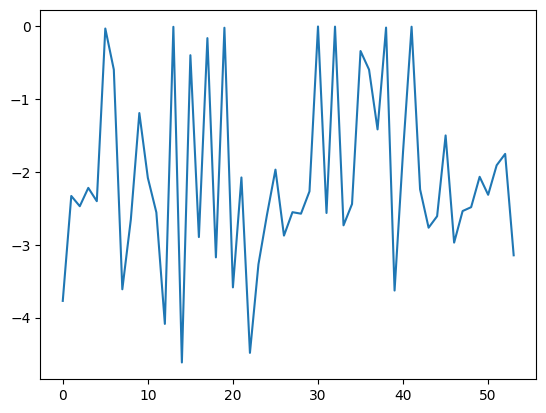

In [25]:
from matplotlib import pyplot as plt
plt.plot(result['token_log_plls'])

In [10]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from Bio import PDB
import io

# Test path
TEST_PATH = Path("/home/naka/code/egfr_binder_rd2/data/colabfold_outputs/high_quality_folded")

def three_to_one(three_letter_code):
    aa_dict = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    return aa_dict.get(three_letter_code, 'X')

def extract_sequence_from_pdb(pdb_content):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", io.StringIO(pdb_content))
    
    sequences = {'A': '', 'B': ''}
    for model in structure:
        for chain in model:
            chain_id = chain.id
            if chain_id in sequences:
                for residue in chain:
                    if PDB.is_aa(residue, standard=True):
                        sequences[chain_id] += three_to_one(residue.get_resname())
    
    return {
        'binder': sequences.get('A', ''),
        'target': sequences.get('B', ''),
    }

# Process one example sequence hash
def process_one_example():
    # Find all score files for one sequence hash
    score_files = list(TEST_PATH.glob("*_scores_rank_*.json"))
    if not score_files:
        print("No score files found")
        return
    
    example_score_file = score_files[0]
    print(f"\nProcessing example file: {example_score_file.name}")
    
    # Extract parts from filename
    # Format: hash_scores_rank_001_alphafold2_multimer_v3_model_5_seed_002.json
    parts = example_score_file.stem.split('_')
    print({i: p for i, p in enumerate(parts)})
    seq_hash = parts[0]
    rank = int(parts[3])
    model_num = parts[8]  # Just the number part
    seed_num = parts[10]   # Just the number part
    
    print(f"Hash: {seq_hash}")
    print(f"Rank: {rank:03d}")
    print(f"Model: {model_num}")
    print(f"Seed: {seed_num}")
    
    # Find corresponding PDB file
    expected_pdb = TEST_PATH / f"{seq_hash}_unrelaxed_rank_{rank:03d}_alphafold2_multimer_v3_model_{model_num}_seed_{seed_num}.pdb"
    print(f"\nLooking for PDB file: {expected_pdb.name}")
    print(f"PDB file exists: {expected_pdb.exists()}")
    
    if expected_pdb.exists():
        # Read PDB file
        with open(expected_pdb, 'r') as f:
            pdb_content = f.read()
            sequences = extract_sequence_from_pdb(pdb_content)
        print("\nExtracted sequences:")
        print(f"Binder sequence: {sequences['binder']}")
        print(f"Binder length: {len(sequences['binder'])}")
        print(f"Target length: {len(sequences['target'])}")
        
        # Read scores
        with open(example_score_file, 'r') as f:
            scores_data = json.load(f)
        print("\nScore data keys:", list(scores_data.keys()))
        print("iptm:", scores_data.get('iptm'))
        print("ptm:", scores_data.get('ptm'))
        
        # Read PAE
        pae_file = TEST_PATH / f"{seq_hash}_predicted_aligned_error_v1.json"
        if pae_file.exists():
            with open(pae_file, 'r') as f:
                pae_data = json.load(f)
            print("\nPAE data keys:", list(pae_data.keys()))
            pae_matrix = np.array(pae_data['predicted_aligned_error'])
            binder_len = len(sequences['binder'])
            
            binder_pae = pae_matrix[:binder_len, :binder_len].mean()
            target_pae = pae_matrix[binder_len:, binder_len:].mean()
            interface_pae = (
                pae_matrix[:binder_len, binder_len:].mean() +
                pae_matrix[binder_len:, :binder_len].mean()
            ) / 2
            
            print(f"\nPAE metrics:")
            print(f"Binder PAE: {binder_pae:.3f}")
            print(f"Target PAE: {target_pae:.3f}")
            print(f"Interface PAE: {interface_pae:.3f}")

# Run the example
process_one_example()

# Print all files for the example sequence
if score_files:
    seq_hash = score_files[0].stem.split('_')[0]
    print(f"\nAll files for sequence {seq_hash}:")
    all_files = list(TEST_PATH.glob(f"{seq_hash}*"))
    for f in sorted(all_files):
        print(f"  {f.name}")


Processing example file: d64fe1_scores_rank_008_alphafold2_multimer_v3_model_4_seed_002.json
{0: 'd64fe1', 1: 'scores', 2: 'rank', 3: '008', 4: 'alphafold2', 5: 'multimer', 6: 'v3', 7: 'model', 8: '4', 9: 'seed', 10: '002'}
Hash: d64fe1
Rank: 008
Model: 4
Seed: 002

Looking for PDB file: d64fe1_unrelaxed_rank_008_alphafold2_multimer_v3_model_4_seed_002.pdb
PDB file exists: True

Extracted sequences:
Binder sequence: SLFSRCPRRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELDIRYLLLLN
Binder length: 54
Target length: 621

Score data keys: ['plddt', 'max_pae', 'pae', 'ptm', 'iptm']
iptm: 0.95
ptm: 0.84

PAE data keys: ['predicted_aligned_error', 'max_predicted_aligned_error']

PAE metrics:
Binder PAE: 3.583
Target PAE: 8.123
Interface PAE: 7.948

All files for sequence d64fe1:
  d64fe1.a3m
  d64fe1.done.txt
  d64fe1_coverage.png
  d64fe1_env
  d64fe1_pae.png
  d64fe1_pairgreedy
  d64fe1_plddt.png
  d64fe1_predicted_aligned_error_v1.json
  d64fe1_scores_rank_001_alphafold2_multimer_v3_model_2_seed_002